# Q Learning

## Summary

- Custom Grid Environment (refer to grid_environment folder for more information)
- Class for Q Learning algorithm
- Q Learning implementation on custom grid environment
- Analysis of Q Learning implementation

## Code

In [2]:
# Imports

import cv2
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

### RL Grid Environment

In [3]:
# Grid Environment Class

class GridEnvironment(gym.Env):    
    def __init__(self, environment_type):
        self.environment_type = environment_type
        self.environment_width = 6
        self.environment_height = 6
        
        self.observation_space = gym.spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = gym.spaces.Discrete(4)
        
        self.max_timesteps = 20
        self.timestep = 0          
        self.agent_pos = np.asarray([0, 0])
        self.current_state = np.asarray([0, 0])
        self.next_state = np.asarray([0, 0])
        self.gold_pos = np.asarray([4, 5])
        self.gold_quantity = 1
        self.coin_pos = np.asarray([[0,2], [0,4], [1,5], [2,0], [2,2], [2,5], [3,3], [4,0], [4,4], [5,5]])
        self.stack_pos = np.asarray([[1,3], [4,1]]) 
        self.pit_pos = np.asarray([[0,3], [1,1], [2,4], [3,0], [4,2], [5,0], [5,3]])
        
    def reset(self, **kwargs):
        self.timestep = 0          
        self.agent_pos = np.asarray([0, 0])
        self.agent_pos = np.asarray([0, 0])
        self.current_state = np.asarray([0, 0])
        self.gold_pos = np.asarray([4, 5])
        self.gold_quantity = 1
        self.coin_pos = np.asarray([[0,2], [0,4], [1,5], [2,0], [2,2], [2,5], [3,3], [4,0], [4,4], [5,5]])
        self.stack_pos = np.asarray([[1,3], [4,1]]) 
        self.pit_pos = np.asarray([[0,3], [1,1], [2,4], [3,0], [4,2], [5,0], [5,3]])
            
        return self.current_state
        
    def step(self, action):
       
        # Stochastic Environment
        random_number = np.random.uniform(0, 1)
        if self.environment_type == 'stochastic' and random_number >= 0.9:
            action = np.random.choice(self.action_space.n)
            
        if action == 0:
            self.agent_pos[0] += 1  # This action causes the agent to go right.
        if action == 1:
            self.agent_pos[0] -= 1  # This action causes the agent to go left.
        if action == 2:
            self.agent_pos[1] += 1  # This action causes the agent to go up.
        if action == 3:
            self.agent_pos[1] -= 1  # This action causes the agent to go down.

        self.agent_pos = np.clip(self.agent_pos, 0, 5) 
        
        self.next_state = self.agent_pos
        
        terminated = True if self.timestep >= self.max_timesteps else False
        truncated = True if np.all((self.agent_pos >= 0 ) & (self.agent_pos <= 2)) else False
        
        reward = 0
        agent_list = self.agent_pos.tolist()
        gold_list = self.gold_pos.tolist()
        coin_list = self.coin_pos.tolist()
        stack_list = self.stack_pos.tolist()
        pit_list = self.pit_pos.tolist()         
        
        if agent_list == gold_list:
            reward = 100
            self.gold_pos = np.asarray([])
            terminated = True
        if agent_list in coin_list:
            reward = 1
            coin_list.remove(agent_list)
            self.coin_pos = np.asarray(coin_list)
        if agent_list in stack_list:
            reward = 10
            stack_list.remove(agent_list)
            self.stack_pos = np.asarray(stack_list)
        if agent_list in pit_list:
            reward = -2
            pit_list.remove(agent_list)
            self.pit_pos = np.asarray(pit_list)
        
        self.timestep += 1
        
        return self.next_state, reward, terminated

### Q-Learning Algorithm

In [4]:
# Q-Learning Algorithm class

class QLearning():
    def __init__(self, environment):
        self.environment = environment
        self.observation_space = environment.observation_space.n
        self.action_space = environment.action_space.n
        
        self.q_table = np.zeros((self.observation_space, self.action_space))        
        
        self.num_episodes = 10000
        self.iter_episodes = 100

        self.gamma = 0.99
        self.alpha = 0.1

        self.epsilon = 1
        self.decay_factor = 0.001
        self.min_epsilon = 0.01

        self.rewards_per_episode = []
        self.iterations_per_episode = []
        self.iterations = []
        for e in range(self.num_episodes):
            self.iterations.append(e)
        self.epsilon_values = []
        
    def map_state(self):
        state_map = [0] * self.observation_space
        iter_val = int(np.sqrt(self.observation_space))
        s = 0
        for i in range(iter_val):
            for j in range(iter_val):
                state_map[s] = [i, j]
                s += 1
        return state_map
    
    def choose_action(self, current_state):
        # epsilon greedy
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            action = np.argmax(self.q_table[current_state,:])
        return action
            
    def update(self):
        state_map = self.map_state()
        for e in range(self.num_episodes):
            current_state = self.environment.reset()
            terminated, truncated = False, False

            total_reward = 0

            for i in range(self.iter_episodes):
                current_index = state_map.index(current_state.tolist())
                action = self.choose_action(current_index)

                next_state, reward, terminated = self.environment.step(action)

                next_index = state_map.index(next_state.tolist())
                next_state_max = np.max(self.q_table[next_index])

                # Q-Learning update function
                self.q_table[current_index, action] = self.q_table[current_index, action] + \
                    self.alpha*(reward + self.gamma*next_state_max - self.q_table[current_index, action])

                total_reward += reward

                if terminated:
                    break

                current_state = next_state

            self.iterations_per_episode.append(i)
            self.rewards_per_episode.append(total_reward)
            self.epsilon_values.append(self.epsilon)

            self.epsilon = max(self.min_epsilon, np.exp(-self.decay_factor*e))        

In [5]:
grid_world = GridEnvironment('deterministic')
q_learning = QLearning(grid_world)

q_learning.update()

In [6]:
# Q Table

q_learning.q_table

array([[ 9.67776072e+01,  9.81881787e+01,  1.04859800e+02,
         9.88319741e+01],
       [ 9.70728002e+01,  9.93723027e+01,  1.05919080e+02,
         9.86591567e+01],
       [ 1.05978900e+02,  9.92186914e+01,  9.72556794e+01,
         9.95483402e+01],
       [ 1.00742925e+02,  9.81609336e+01,  9.79553018e+01,
         9.76666793e+01],
       [ 9.80095434e+01,  9.69635833e+01,  9.70268151e+01,
         9.70921365e+01],
       [ 4.53923895e+01,  1.84428764e+01,  5.26012556e+01,
         9.79103126e+01],
       [ 9.56278419e+01,  9.54773812e+01,  9.78839919e+01,
         9.55722983e+01],
       [ 9.69059612e+01,  9.71112975e+01,  9.99911318e+01,
         9.67464755e+01],
       [ 9.82424426e+01,  9.82776573e+01,  1.07049402e+02,
         9.82792623e+01],
       [ 9.78804266e+01,  9.76065797e+01,  9.80297007e+01,
         9.79475058e+01],
       [ 9.55099345e+01,  9.77910400e+01,  9.90199000e+01,
         9.70222097e+01],
       [ 9.90100000e+01,  9.58407831e+01,  9.58812849e+01,
      

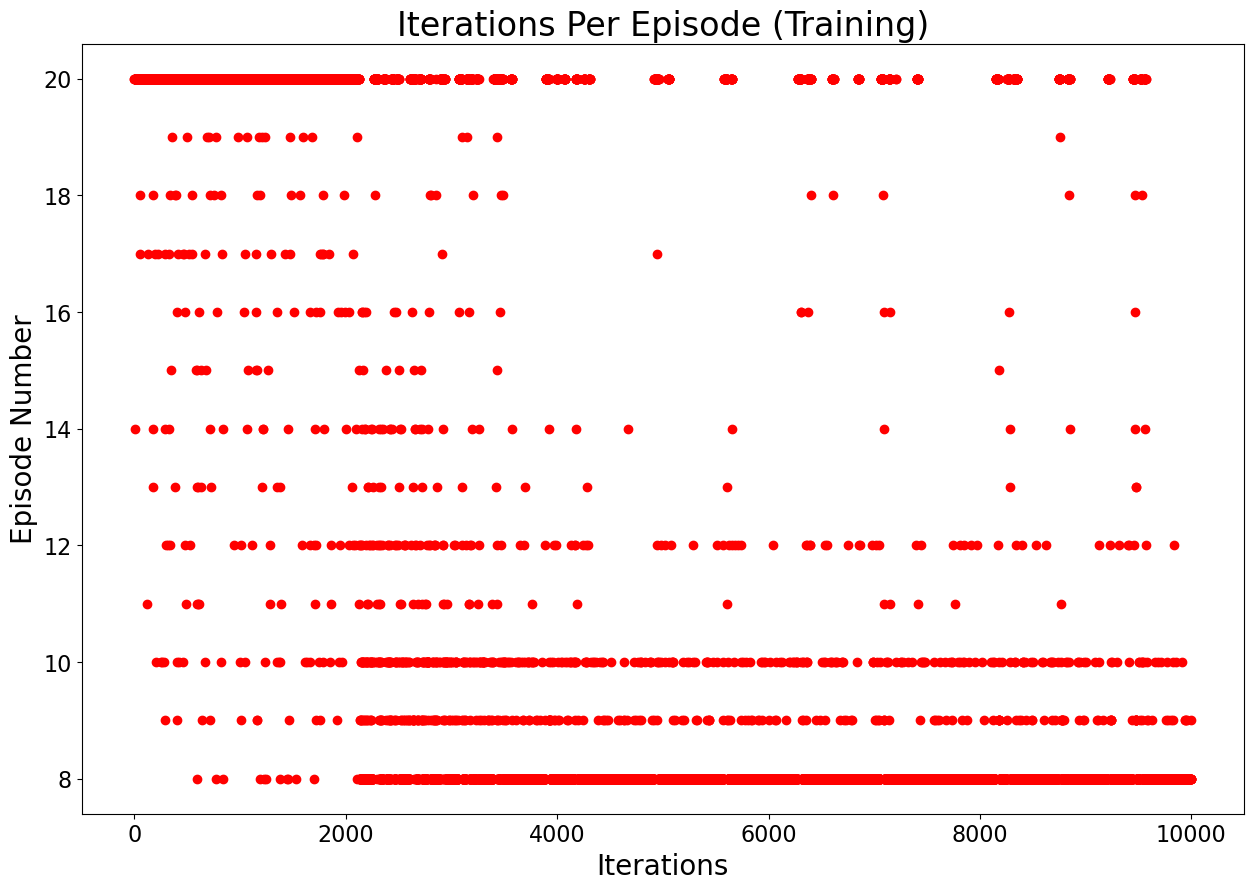

In [7]:
# Number of iterations per epsisode

plt.figure(figsize=(15, 10))
plt.plot(q_learning.iterations, q_learning.iterations_per_episode, 'ro')
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('Episode Number', fontsize=20)
plt.title('Iterations Per Episode (Training)', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

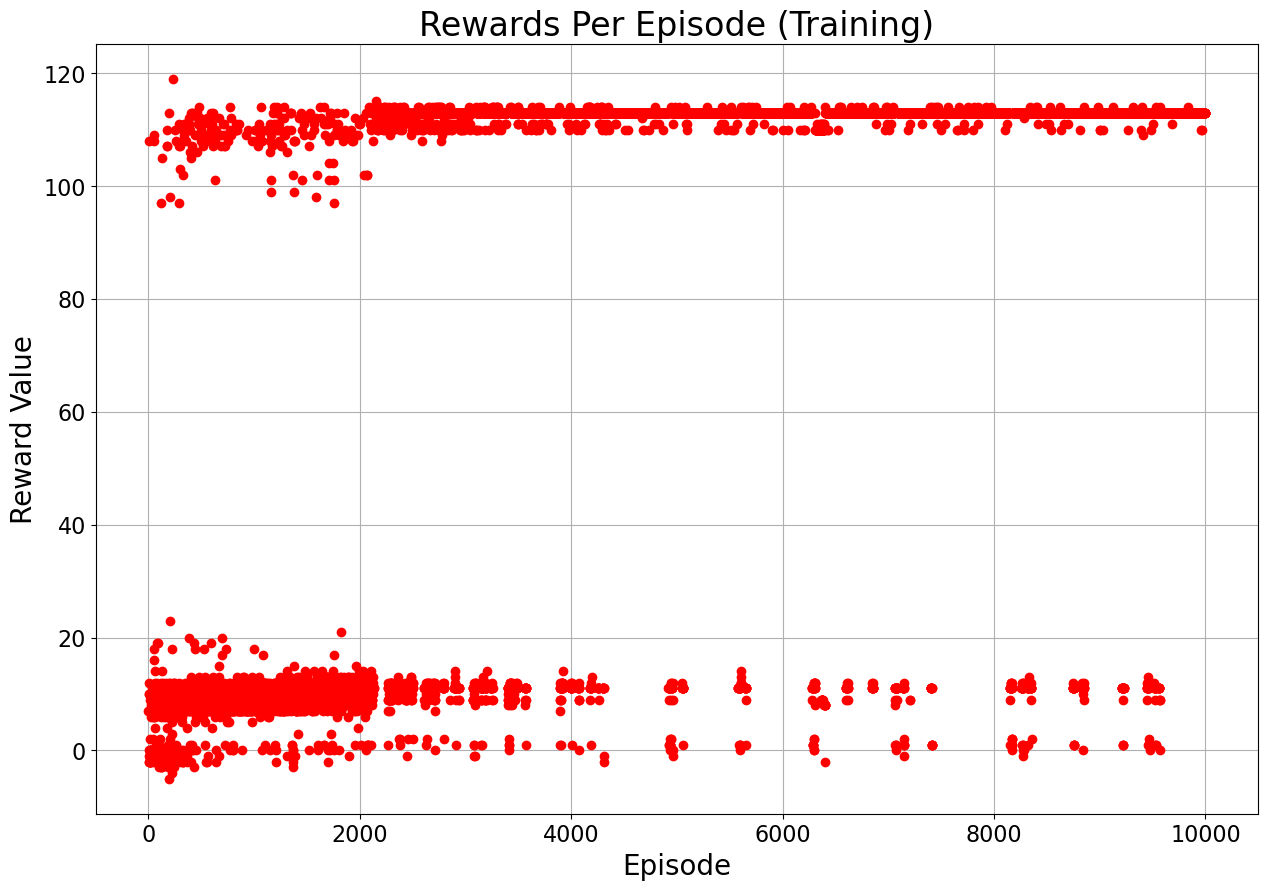

In [8]:
# Reward value per episode

plt.figure(figsize=(15, 10))
plt.plot(q_learning.rewards_per_episode, 'ro')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward Value', fontsize=20)
plt.title('Rewards Per Episode (Training)', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.show()

In [9]:
# Mean reward per thousand episode

mean_reward = []
iteration_thousand = []
print("Mean reward per thousand episodes")
for i in range(10):
    mean_reward.append(np.mean(q_learning.rewards_per_episode[1000*i:1000*(i+1)]))
    iteration_thousand.append((i+1)*1000)
    print(((i+1)*1000), ': mean reward :', mean_reward[i])

Mean reward per thousand episodes
1000 : mean reward : 16.939
2000 : mean reward : 20.328
3000 : mean reward : 78.865
4000 : mean reward : 93.15
5000 : mean reward : 103.572
6000 : mean reward : 107.501
7000 : mean reward : 104.673
8000 : mean reward : 106.808
9000 : mean reward : 102.175
10000 : mean reward : 106.126


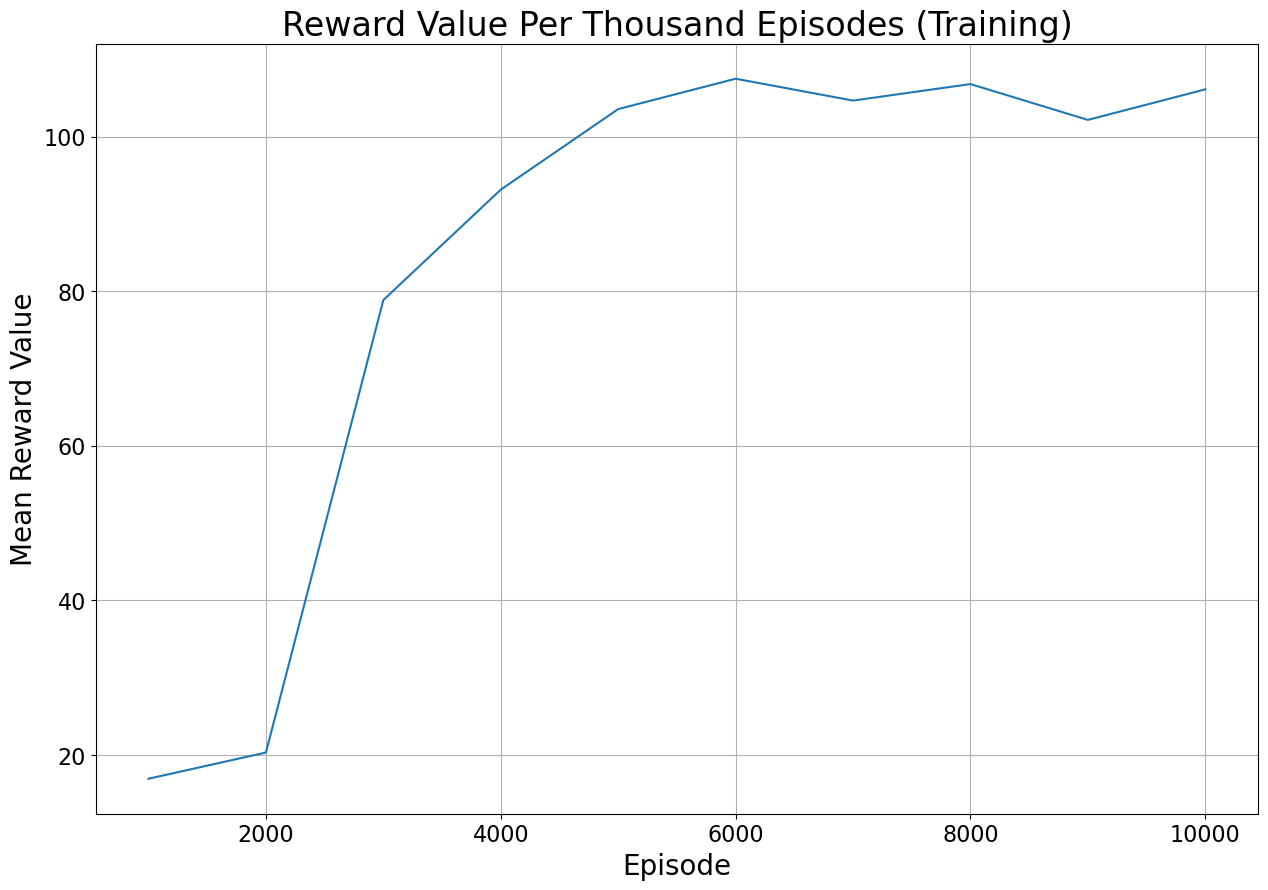

In [10]:
plt.figure(figsize=(15, 10))
plt.plot(iteration_thousand, mean_reward)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Mean Reward Value', fontsize=20)
plt.title('Reward Value Per Thousand Episodes (Training)', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.show()

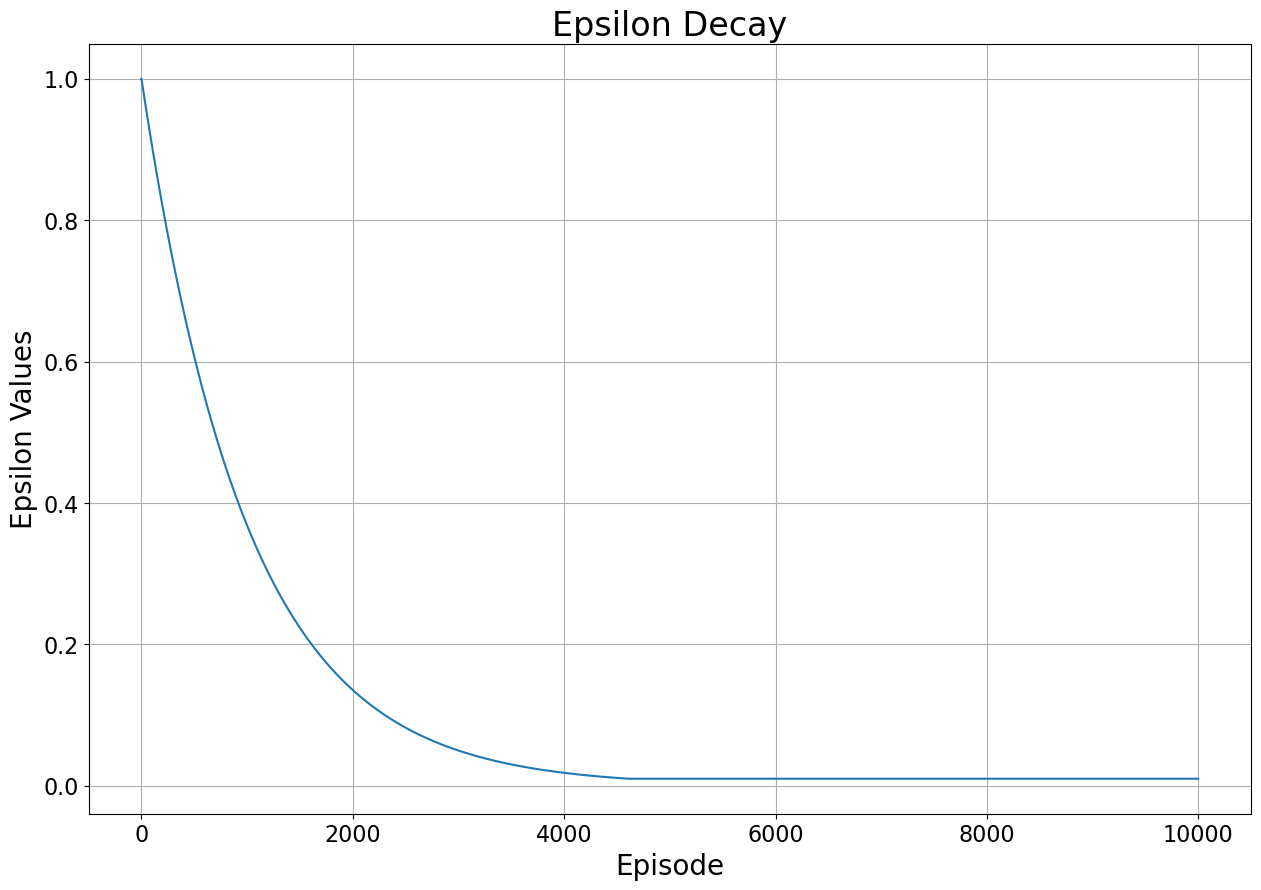

In [11]:
# Epsilon decay

plt.figure(figsize=(15, 10))
plt.plot(q_learning.epsilon_values)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Epsilon Values', fontsize=20)
plt.title('Epsilon Decay', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.show()